# Disease Spread

With the outbreak of the *coronavirus* (COVID-19) in late 2019 and early 2020 there has been an increased interest in modeling the impacts of epidemic and pandemic. Live organisms, and particularly human beings, interact in cmplex ways and are highly dynamic, so trying to capture every movement, every surface touched, every contact between two or more individuals for every human being seems impossible. 

However, with the increasing number of georeferenced information about our commuting patterns, traffic congestions, maps of roads and subways, population demographics, improved weather observation and forecasts, and overall knowledge about human activity simulations are becoming increasingly more detailed.

Incorporating these and many more variables, even for a small country, could take substantil computing power and an interdisciplinary group of scientists. In this exercise we will implement a simplistic simulation to analyze the impact of few paramters on the spread of a made-up disease within an arbitrary small population. We will take into account social distancing and rate at which individuals move. The goal is to learn how to implement simple interactions.

The code below is by no means intended for research use, but it may serve as the basis for creating simple models with few individuals or animals, perhaps something like the spread of a disease within animals in a pasture.


## Ground rules and code decisions

- Dead people will be masked from computations by assigning a value of NaN (using `np.nan`).

- During the computation of distance, self individuals will be assigned a value of Inf (using `np.inf`). 

- The model assumes an establish population with no birth rate.

- The model does not considered the race, age, sex, or physical condition of the individuals.


In [40]:
# Import modules
import numpy as np
import matplotlib.pyplot as plt
import time
from IPython.display import clear_output

import warnings
warnings.filterwarnings("ignore",category =RuntimeWarning)


In [41]:
# Define function to compute euclidean distance between individuals
def edist(x,y):
    df = np.kron(np.ones(N),[x,y]) - np.kron([x,y],np.ones(N)) # Compute differences using Kronecker product
    E = np.sqrt(df[0]**2 + df[1]**2) # Compute Euclidean distance.
    E = np.reshape(E,[N,N])
    return E


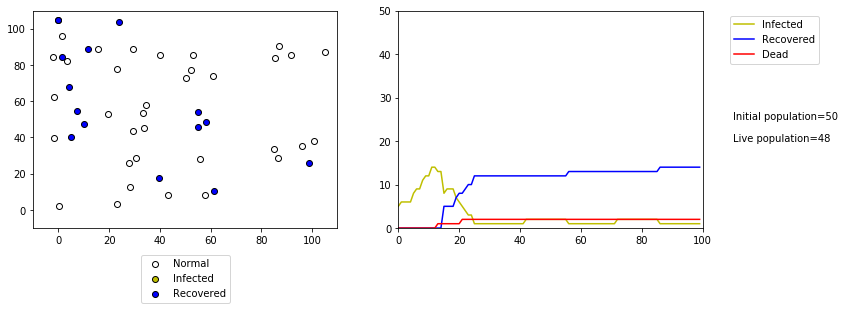

51


In [127]:
# Simulation space and time constraints
xmin = 0      # Left system boundary
xmax = 100    # Right system boundary
ymin = 0      # Lower system boundary
ymax = 100    # Upper system boundary
T = 100       # Number of time steps

# Existing population
N = 50       # Number of live individuals
live = np.ones(N, dtype=bool)
dead = np.zeros(N, dtype=bool)

# Initial health conditions
normal = np.ones(N, dtype=bool)
infected = np.zeros(N, dtype=bool)
recovered = np.zeros(N, dtype=bool)

# Initial positions and directions of live individuals
x = np.random.uniform(xmin,xmax,N)
y = np.random.uniform(ymin,ymax,N)
theta = np.radians(np.random.uniform(0,360,N))

# Compute percentage of people circulating
activity_rate = np.ones(N)    
fraction_static = 0.0  # Change this to keep people static (at home)
static_individuals = np.random.randint(low=0, high=N, size=round(N*fraction_static))
activity_rate[static_individuals] = 0 

# Social distancing
social_distance = 5 # arbitrary units

# Death rate 
death_rate = 2/100

# Initialize quanrentine time for infected
quarentine_time = np.zeros(N)

# Inoculate a small group of individuals
infected_seeds = np.random.randint(low=0, high=N, size=5)
infected[infected_seeds] = True
normal[infected_seeds] = False

# Initialize totals
total_live = live.sum()
total_dead = dead.sum()
total_normal = normal.sum()
total_infected = infected.sum()
total_recovered = recovered.sum()

# Start recursive iteration
for t in range(1,T):
   
    # Compute next positions of individuals
    x = x + activity_rate * np.cos(theta)
    y = y + activity_rate * np.sin(theta)
    
    # Handle interaction with system boundaries.
    idx_x = (x <= xmin) | (x >= xmax)
    idx_y = (y <= ymin) | (y >= ymax)
    idx_bnd = idx_x | idx_y

    # Change trajectory angle if hit boundary
    theta[idx_bnd] = np.random.uniform(0,360,np.sum(idx_bnd)) # np.abs(theta[idx_bnd] - 45) #
    
    # Determine whether two individuals come in contact
    E = edist(x,y)
    E[np.eye(N, dtype='bool')] = np.inf # Set selfs to inf to avoid being selected.
    rows,cols = np.where(E <= social_distance)
    #idx_contact = np.zeros(N, dtype="bool")
    #idx_contact[rows] = True
    
    # Change trajectory angle if contact between two people
    #theta[idx_contact] = np.random.uniform(0,360,np.sum(idx_contact))

    # New infected live individuals
    idx_infected = infected[rows] | infected[cols]
    infected[rows[idx_infected]] = True
    normal[rows[idx_infected]] = False
    
    # Recovery of infected individuals that reached quarentine
    quarentine_time[infected] += 1
    idx_recovered = quarentine_time == 15
    quarentine_time[idx_recovered] = 0
    recovered[idx_recovered] = True
    normal[idx_recovered] = False
    infected[idx_recovered] = False
    
    # Remove dead individuals from population
    idx_potential_dead = infected & (quarentine_time > 10)
    daily_probability_dead = np.random.rand(N)
    daily_probability_dead[~idx_potential_dead] = 0 # Unnecessary line, but left for completeness and logic
    idx_dead = daily_probability_dead >= (1-death_rate)
    dead[idx_dead] = True
    
    # Update live population counts
    live[idx_dead] = False
    infected[idx_dead] = False
    recovered[idx_dead] = False
    normal[idx_dead] = False
    quarentine_time[idx_recovered] = np.nan
    x[idx_dead] = np.nan
    y[idx_dead] = np.nan
    theta[idx_dead] = np.nan
    
    # Compute totals
    total_live = np.append(total_live,live.sum())
    total_dead = np.append(total_dead,dead.sum())
    total_normal = np.append(total_normal,normal.sum())
    total_infected = np.append(total_infected,infected.sum())
    total_recovered = np.append(total_recovered,recovered.sum())
    
    # Plot chart with current positions and health
    clear_output(wait=True)
    plt.figure(figsize=(12,4))
    plt.subplot(1,2,1)
    plt.scatter(x[normal],y[normal],marker='o',facecolor='w',edgecolor='k',label='Normal')
    plt.scatter(x[infected],y[infected],marker='o',facecolor='y',edgecolor='k',label='Infected')
    plt.scatter(x[recovered],y[recovered],marker='o',facecolor='b',edgecolor='k',label='Recovered')
    plt.legend(loc='upper center', bbox_to_anchor=(0.5,-0.1))
    
    # Set limits of the plot to improve rendering at the boundaries
    plt.xlim(xmin-10,xmax+10)
    plt.ylim(ymin-10,ymax+10)
    
    # Plot progression of health condition
    plt.subplot(1,2,2)
    plt.plot(range(t+1),total_infected, '-y',label='Infected')
    plt.plot(range(t+1),total_recovered, '-b',label='Recovered')
    plt.plot(range(t+1),total_dead, '-r',label='Dead')
    plt.annotate("Initial population="+str(live.size), xy=(T+10,N/2), annotation_clip=False)
    plt.annotate("Live population="+str(live.sum()), xy=(T+10,N/2.5), annotation_clip=False)
    plt.xlim(0,T)
    plt.ylim(0,N)
    plt.legend(loc='upper right',bbox_to_anchor=(1.4,1))
    plt.show()
    print(normal.sum() + recovered.sum() + infected.sum() + dead.sum())
    

In [131]:
np.sum(infected & recovered)

1

In [128]:
print(infected)
print(idx_infected)

[False False False False False False False False False False False False
 False False False  True False False False False False False False False
 False False False False False False False False False False False False
 False False False False False False False False False False False False
 False False]
[False False False False False False False False False False False False
 False False False False]


In [130]:
print(rows)
print(cols)

[ 1  4  6 12 13 14 17 23 25 35 37 37 38 40 43 48]
[37 43 38 48 23 40 37 13 35 25  1 17  6 14  4 12]


In [129]:
rows[idx_infected]

array([], dtype=int64)

In [107]:
print(infected[rows])
print(infected[cols])
print(infected[idx_contact])

[False  True  True False False  True]
[False  True  True  True False False]
[False  True  True False False  True]
